In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys, os, time
from pathlib import Path
from tqdm import tqdm

import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [3]:
mnist = datasets.FashionMNIST()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

In [4]:
input_size = 784
output_size = 10

learning_rate = 0.0001
batch_size = 50

train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [5]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)

### Model Development

In [6]:
### does binary like encoding but continuous sin and cos
def generate_dimension_encoding(dim, binarize=True):
    num_d = int(np.ceil(np.log2(dim)))
    scale = np.arange(0, num_d, 1).reshape(1,-1)
    scale = (1/2)**scale
    
    index = np.arange(0, dim, 1).reshape(-1,1)
    mat = index*scale
    
    if binarize:
        mat = mat*np.pi/2
    sin_mat = np.sin(mat)**2
    cos_mat = np.cos(mat)**2
    pos_mat = np.concatenate((sin_mat, cos_mat), axis=1)
    return torch.Tensor(pos_mat)

### does exact binary encoding of position
def generate_dimension_encoding2(dim):
    num_d = int(np.ceil(np.log2(dim)))
    pos_mat = np.empty((dim, num_d))
    for i in range(dim):
        binary = np.binary_repr(i, width=num_d)
        pos_mat[i] = [float(a) for a in binary]
    
    pos_mat = np.concatenate((pos_mat, 1-pos_mat), axis=1)
    return torch.Tensor(pos_mat)


### does sin and cosine of position (meant to be used as addition)
def generate_dimension_encoding3(dim, binarize=False):
    num_d = int(np.ceil(np.log2(dim)))
    scale = np.arange(0, num_d, 1).reshape(1,-1)
    scale = (1/2)**scale
    
    index = np.arange(0, dim, 1).reshape(-1,1)
    mat = index*scale
    if binarize:
        mat = mat*np.pi/2
    sin_mat = np.sin(mat)
    cos_mat = np.cos(mat)
    pos_mat = np.concatenate((sin_mat, cos_mat), axis=1)
    return torch.Tensor(pos_mat)

#### as in positional encoding of attention transformer (as addition)
def generate_dimension_encoding4(dim, binarize=False):
    num_d = int(np.ceil(np.log2(dim)))
    scale = np.arange(0, num_d, 1).reshape(1,-1)
    scale = (1/10000)**(scale*2/dim)
    
    index = np.arange(0, dim, 1).reshape(-1,1)
    mat = index*scale
    if binarize:
        mat = mat*np.pi/2
    sin_mat = np.sin(mat)
    cos_mat = np.cos(mat)
    pos_mat = np.concatenate((sin_mat, cos_mat), axis=1)
    return torch.Tensor(pos_mat)

In [7]:
# class Layer_DimEncMLP_mul(nn.Module):
#     def __init__(self, dim, hidden_ratio = [2], activation=nn.ReLU()):
#         super().__init__()
#         self.dim = dim
        
#         self.pos_mat = generate_dimension_encoding(dim)
# #         self.pos_mat = torch.cat((self.pos_mat, torch.ones(dim, 1)), dim=1)
#         mlp_inp_dim = self.pos_mat.shape[1]
#         la_dims = [mlp_inp_dim]
#         for hr in hidden_ratio:
#             la_dims.append(int(hr*mlp_inp_dim))
#         la_dims.append(1)
        
#         layers = []
#         for i in range(len(la_dims)-1):
#             _a = nn.Linear(la_dims[i], la_dims[i+1])
#             layers += [_a, activation]
#         layers = layers[:-1]
#         layers[-1].weight.data *= 0.
#         self.net = nn.Sequential(*layers)
        
#         self.pos_mat = nn.Parameter(self.pos_mat)
# #         self.norm = nn.LayerNorm(dim)
        
#     def forward(self, x):
# #         x = self.norm(x)
#         num_d = self.pos_mat.shape[1]
#         encodedX = (x.unsqueeze(dim=2)*self.pos_mat.unsqueeze(dim=0))
#         y = self.net(encodedX.reshape(-1, num_d)).reshape(x.shape)
#         return y


# class Layer_DimEncMLP_cat(nn.Module):
#     def __init__(self, dim, hidden_ratio = [2], activation=nn.ReLU()):
#         super().__init__()
#         self.dim = dim
        
#         self.pos_mat = generate_dimension_encoding(dim)
#         mlp_inp_dim = self.pos_mat.shape[1]
#         la_dims = [mlp_inp_dim+1]
#         for hr in hidden_ratio:
#             la_dims.append(int(hr*mlp_inp_dim))
#         la_dims.append(1)
        
#         layers = []
#         for i in range(len(la_dims)-1):
#             _a = nn.Linear(la_dims[i], la_dims[i+1])
#             layers += [_a, activation]
#         layers = layers[:-1]
#         self.net = nn.Sequential(*layers)
        
#         self.pos_mat = nn.Parameter(self.pos_mat)
# #         self.norm = nn.LayerNorm(dim)
        
#     def forward(self, x):
# #         x = self.norm(x)
#         num_d = self.pos_mat.shape[1]
#         encodedX = torch.cat([\
#                               x.unsqueeze(dim=2),\
#                               self.pos_mat.expand(x.shape[0], *self.pos_mat.shape)\
#                              ],\
#                              dim=2)
#         y = self.net(encodedX.reshape(-1, num_d+1)).reshape(x.shape)
#         return y
    
    
# class Layer_DimEncMLP_add(nn.Module):
#     def __init__(self, dim, hidden_ratio = [2], activation=nn.ReLU()):
#         super().__init__()
#         self.dim = dim
        
#         self.pos_mat = generate_dimension_encoding4(dim)
# #         self.pos_mat = torch.cat((self.pos_mat, torch.ones(dim, 1)), dim=1)
#         mlp_inp_dim = self.pos_mat.shape[1]
#         la_dims = [mlp_inp_dim]
#         for hr in hidden_ratio:
#             la_dims.append(int(hr*mlp_inp_dim))
#         la_dims.append(1)
        
#         layers = []
#         for i in range(len(la_dims)-1):
#             _a = nn.Linear(la_dims[i], la_dims[i+1])
#             layers += [_a, activation]
#         layers = layers[:-1]
#         self.net = nn.Sequential(*layers)
#         self.pos_mat = nn.Parameter(self.pos_mat)
# #         self.norm = nn.LayerNorm(dim)
        
#     def forward(self, x):
# #         x = self.norm(x)
#         num_d = self.pos_mat.shape[1]
#         encodedX = (x.unsqueeze(dim=2)+self.pos_mat.unsqueeze(dim=0))
#         y = self.net(encodedX.reshape(-1, num_d)).reshape(x.shape)
#         return y

In [8]:
dim = 16
pair = 2

X = torch.randn(2,dim)
if dim%pair != 0 :
    raise ValueError(f"Dim: {dim} should be exactly divisible by Pair: {pair}")
pos_mat = generate_dimension_encoding2(dim//pair)
pos_mat

tensor([[0., 0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1., 0.],
        [0., 1., 0., 1., 0., 1.],
        [0., 1., 1., 1., 0., 0.],
        [1., 0., 0., 0., 1., 1.],
        [1., 0., 1., 0., 1., 0.],
        [1., 1., 0., 0., 0., 1.],
        [1., 1., 1., 0., 0., 0.]])

In [9]:
pos_mat.shape

torch.Size([8, 6])

In [10]:
X.reshape(-1, dim//pair, pair).shape

torch.Size([2, 8, 2])

In [11]:
linear = nn.Linear(pair, pos_mat.shape[1])

In [12]:
x = linear(X.reshape(-1, pair))
x.shape

torch.Size([16, 6])

In [13]:
x.reshape(-1, *pos_mat.shape).shape, pos_mat.unsqueeze(dim=0).shape

(torch.Size([2, 8, 6]), torch.Size([1, 8, 6]))

In [14]:
x_ = x.reshape(-1, *pos_mat.shape)+pos_mat.unsqueeze(dim=0)
x_ = x_.reshape(-1, pos_mat.shape[1])
x_.shape

torch.Size([16, 6])

In [15]:
def construct_sequential_mlp(layer_dims, activation):
    layers = []
    for i in range(len(layer_dims)-1):
        _a = nn.Linear(layer_dims[i], layer_dims[i+1])
        layers += [_a, activation]
    layers = layers[:-1]
    return nn.Sequential(*layers)

class DimMix_Layer_add(nn.Module):
    
    def __init__(self,dim, pair, out_pair=None, hidden_ratio = [2], activation=nn.ReLU()):
        super().__init__()
        self.dim = dim
        self.pair = pair
        self.out_pair = out_pair
        if out_pair is None:
            self.out_pair = pair
        if dim%pair != 0 :
            raise ValueError(f"Dim: {dim} should be exactly divisible by Pair: {pair}")

        self.pos_mat = generate_dimension_encoding4(dim//pair)
        self.pos_mat = nn.Parameter(self.pos_mat)
        
        self.linear = nn.Linear(pair, self.pos_mat.shape[1])
        
        inp_dim = self.pos_mat.shape[1]
        la_dims = [inp_dim] + [int(hr*inp_dim) for hr in hidden_ratio] + [self.out_pair]
        self.net = construct_sequential_mlp(la_dims, activation)
        
    def forward(self, x):
        xs = x.shape
        _x = self.linear(x.reshape(-1, self.pair))
        _x = _x.reshape(-1, *self.pos_mat.shape)+self.pos_mat.unsqueeze(dim=0)
        _x = self.net(_x.reshape(-1, self.pos_mat.shape[1]))
        _x = _x.reshape(xs[0], -1)
        return _x

In [16]:
DimMix_Layer_add(dim, pair)(X).shape

torch.Size([2, 16])

In [17]:
dim = 16
pair = 2

X = torch.randn(2,dim)
if dim%pair != 0 :
    raise ValueError(f"Dim: {dim} should be exactly divisible by Pair: {pair}")
pos_mat = generate_dimension_encoding2(dim//pair)
pos_mat

tensor([[0., 0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1., 0.],
        [0., 1., 0., 1., 0., 1.],
        [0., 1., 1., 1., 0., 0.],
        [1., 0., 0., 0., 1., 1.],
        [1., 0., 1., 0., 1., 0.],
        [1., 1., 0., 0., 0., 1.],
        [1., 1., 1., 0., 0., 0.]])

In [18]:
pos_mat.shape

torch.Size([8, 6])

In [19]:
X.reshape(-1, dim//pair, pair).shape

torch.Size([2, 8, 2])

In [20]:
pos_mat.expand(2, *pos_mat.shape).shape

torch.Size([2, 8, 6])

In [21]:
class DimMix_Layer_cat(nn.Module):
    
    def __init__(self,dim, pair, out_pair=None, hidden_ratio = [2], activation=nn.ReLU()):
        super().__init__()
        self.dim = dim
        self.pair = pair
        self.out_pair = out_pair
        if out_pair is None:
            self.out_pair = pair
        if dim%pair != 0 :
            raise ValueError(f"Dim: {dim} should be exactly divisible by Pair: {pair}")

        self.pos_mat = generate_dimension_encoding4(dim//pair)
        self.pos_mat = nn.Parameter(self.pos_mat)
        
        inp_dim = self.pos_mat.shape[1]+pair
        la_dims = [inp_dim] + [int(hr*inp_dim) for hr in hidden_ratio] + [self.out_pair]
        self.net = construct_sequential_mlp(la_dims, activation)
        
    def forward(self, x):
        xs = x.shape
        _x = x.reshape(-1, self.dim//self.pair, self.pair)
        _pm = self.pos_mat.expand(xs[0], *self.pos_mat.shape)
        _x = torch.cat([_x, _pm], dim=2)
        _x = _x.reshape(-1, self.pos_mat.shape[1]+self.pair)
        _x = self.net(_x).reshape(xs[0], -1)
        return _x

In [22]:
DimMix_Layer_add(dim, pair)(X).shape

torch.Size([2, 16])

In [59]:
class MLP_0(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 50)
        self.l2 = nn.LeakyReLU()
        self.l3 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x
    
class MLP_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 300)
        self.l3 = nn.Linear(300, 10)
        self.l2 = DimMix_Layer_cat(300, 5, hidden_ratio=[5,5], activation=nn.ReLU())
        
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x
    
    
class MLP_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.randindx = torch.randperm(784)
        hr = [5*2,5*2]
        self.l1 = DimMix_Layer_add(784, 8, 4, hidden_ratio=hr, activation=nn.ReLU()) #784/2*1 = 392
        self.l2 = DimMix_Layer_add(392, 8, 2, hidden_ratio=hr, activation=nn.ReLU()) #392/4*1 = 98
        self.l3 = DimMix_Layer_add(98, 7, 3, hidden_ratio=hr, activation=nn.ReLU()) #98/7*3 = 42
        self.l4 = nn.Linear(42, 10)
        
    def forward(self, x):
        x = x[:, self.randindx]
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        return x
    
class MLP_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.randindx = torch.randperm(784)
        hr = [5*2,5*2]
        self.l1 = DimMix_Layer_add(784, 8, 8, hidden_ratio=hr, activation=nn.ReLU()) #784/2*1 = 392
        self.l2 = DimMix_Layer_add(784, 8, 8, hidden_ratio=hr, activation=nn.ReLU()) #392/4*1 = 98
        self.l3 = DimMix_Layer_add(784, 8, 8, hidden_ratio=hr, activation=nn.ReLU()) #98/7*3 = 42
        self.l4 = nn.Linear(784, 10)
        
    def forward(self, x):
        x = x[:, self.randindx]
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        return x


In [60]:
X = torch.randn(2,784)

In [65]:
MLP_3()(X).shape

torch.Size([2, 10])

### Model Training

In [69]:
torch.manual_seed(0)
model = MLP_3().to(device)
model

MLP_3(
  (l1): DimMix_Layer_add(
    (linear): Linear(in_features=8, out_features=14, bias=True)
    (net): Sequential(
      (0): Linear(in_features=14, out_features=140, bias=True)
      (1): ReLU()
      (2): Linear(in_features=140, out_features=140, bias=True)
      (3): ReLU()
      (4): Linear(in_features=140, out_features=8, bias=True)
    )
  )
  (l2): DimMix_Layer_add(
    (linear): Linear(in_features=8, out_features=14, bias=True)
    (net): Sequential(
      (0): Linear(in_features=14, out_features=140, bias=True)
      (1): ReLU()
      (2): Linear(in_features=140, out_features=140, bias=True)
      (3): ReLU()
      (4): Linear(in_features=140, out_features=8, bias=True)
    )
  )
  (l3): DimMix_Layer_add(
    (linear): Linear(in_features=8, out_features=14, bias=True)
    (net): Sequential(
      (0): Linear(in_features=14, out_features=140, bias=True)
      (1): ReLU()
      (2): Linear(in_features=140, out_features=140, bias=True)
      (3): ReLU()
      (4): Linear(in_

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [71]:
## MLP2: number of params:  38390 ; add
## MLP0: number of params:  39760
## MLP2: number of params:  27363 ; add

print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  81248


In [72]:
EPOCHS = 15*3
steps_ = 0
for epoch in range(EPOCHS):
    train_acc = 0
    train_count = 0
    for index in range(train_size // batch_size):
        steps_ += 1

        train_x = train_data[index * batch_size:(index + 1) * batch_size].to(device)
        train_y = train_label[index * batch_size:(index + 1) * batch_size].to(device)

        yout = model(train_x)
        loss = criterion(yout, train_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
        train_acc += (outputs == train_y.data.cpu().numpy()).sum()
        train_count += len(outputs)

        if steps_%500==0:
            train_accuracy = train_acc/train_count
            train_acc, train_count = 0, 0
            
            print(f'\nEpoch: {epoch}, batch: {index}, step: {steps_}, loss: {float(loss)}')
            print(f'\tTrain acc: {train_accuracy*100}%')
            
            with torch.no_grad():
                test_acc, test_count = 0, 0
                model.eval()
                for _ti in range(len(test_data) // batch_size):
                    test_x = test_data[_ti * batch_size:(_ti + 1) * batch_size].to(device)
                    test_y_ = test_label_[_ti * batch_size:(_ti + 1) * batch_size]
                    yout = model(test_x)
                    outputs = tnn.Logits.logit_to_index(yout.cpu().numpy())
                    correct = (outputs == test_y_).sum()
                    test_acc += correct
                    test_count += len(test_x)
                model.train()

            print(f'\tTest acc: {test_acc/test_count*100}%, correct: {test_acc}/{test_count}')


Epoch: 0, batch: 499, step: 500, loss: 0.7893890142440796
	Train acc: 24.004%
	Test acc: 73.95%, correct: 7395/10000

Epoch: 0, batch: 999, step: 1000, loss: 0.833024799823761
	Train acc: 77.708%
	Test acc: 78.55%, correct: 7855/10000

Epoch: 1, batch: 299, step: 1500, loss: 0.7058944702148438
	Train acc: 80.07333333333332%
	Test acc: 79.41%, correct: 7941/10000

Epoch: 1, batch: 799, step: 2000, loss: 0.5032996535301208
	Train acc: 81.144%
	Test acc: 80.25999999999999%, correct: 8026/10000

Epoch: 2, batch: 99, step: 2500, loss: 0.43061932921409607
	Train acc: 82.04%
	Test acc: 80.82000000000001%, correct: 8082/10000

Epoch: 2, batch: 599, step: 3000, loss: 0.3949611783027649
	Train acc: 81.99600000000001%
	Test acc: 79.73%, correct: 7973/10000

Epoch: 2, batch: 1099, step: 3500, loss: 0.6060765385627747
	Train acc: 82.44%
	Test acc: 81.55%, correct: 8155/10000

Epoch: 3, batch: 399, step: 4000, loss: 0.6113049983978271
	Train acc: 82.53%
	Test acc: 82.28999999999999%, correct: 8229/

	Test acc: 84.96000000000001%, correct: 8496/10000

Epoch: 27, batch: 1099, step: 33500, loss: 0.5277106761932373
	Train acc: 87.116%
	Test acc: 84.98%, correct: 8498/10000

Epoch: 28, batch: 399, step: 34000, loss: 0.5163926482200623
	Train acc: 86.39%
	Test acc: 85.28999999999999%, correct: 8529/10000

Epoch: 28, batch: 899, step: 34500, loss: 0.40564411878585815
	Train acc: 87.4%
	Test acc: 85.11999999999999%, correct: 8512/10000

Epoch: 29, batch: 199, step: 35000, loss: 0.24107331037521362
	Train acc: 86.77%
	Test acc: 84.84%, correct: 8484/10000

Epoch: 29, batch: 699, step: 35500, loss: 0.3304288983345032
	Train acc: 86.91600000000001%
	Test acc: 85.37%, correct: 8537/10000

Epoch: 29, batch: 1199, step: 36000, loss: 0.3785318434238434
	Train acc: 87.056%
	Test acc: 85.09%, correct: 8509/10000

Epoch: 30, batch: 499, step: 36500, loss: 0.372461199760437
	Train acc: 86.804%
	Test acc: 84.91%, correct: 8491/10000

Epoch: 30, batch: 999, step: 37000, loss: 0.5982545614242554
	Train

In [30]:
len(test_data)//batch_size

200

In [31]:
## MLP2
# Train acc: 87.96000000000001%
# 	Test acc: 86.27%, correct: 8627/10000
## MLP0
# Train acc: 89.05999999999999%
# 	Test acc: 87.3%, correct: 8730/10000

## Visualize first activations --paired embeddings

In [32]:
### inputs from -1, 1 for every dimension in a batch
X = torch.linspace(-1, 1, steps=20).expand(300, -1).transpose(0,1)
X.shape

torch.Size([20, 300])

In [33]:
model.eval()
ys = model.l2(X.to(device)).data.cpu()
ys.shape

RuntimeError: shape '[-1, 49, 12]' is invalid for input of size 9000

In [ ]:
ys[0]

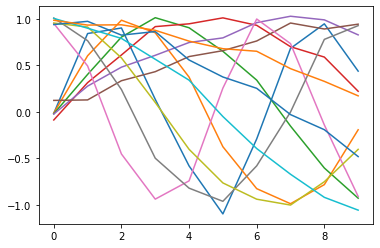

In [34]:
%matplotlib inline
plt.plot(model.l2.pos_mat.cpu().data[:10])

In [ ]:
num_show = 10
for i in range(300):
    plt.plot(X[:,i], ys[:,i])#+X[:,i])
    if (i+1)%num_show == 0:
#         plt.axis("equal")
        plt.show()

In [ ]:
# model = MLP_1()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# print("number of params: ", sum(p.numel() for p in model.parameters()))

In [ ]:
# EPOCHS = 15
# steps_ = 0
# for epoch in range(EPOCHS):
#     train_acc = 0
#     train_count = 0
#     for index in range(train_size // batch_size):
#         steps_ += 1

#         train_x = train_data[index * batch_size:(index + 1) * batch_size]
#         train_y = train_label[index * batch_size:(index + 1) * batch_size]

#         yout = model(train_x)
#         loss = criterion(yout, train_y)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if steps_%500==0:
#             print('\nTRAIN',epoch, steps_, '-> ', float(loss))
# #             yout = model.forward(train_data)
# #             outputs = tnn.Logits.logit_to_index(yout)
# #             correct = (outputs == np.array(train_label_)).sum()

# #             accuracy = correct / len(train_label_) * 100.
# #             print('EPOCH = ','accuracy = ', accuracy)
# #             print(correct, '/', len(train_label_))
            
#             with torch.no_grad():
#                 yout = model(test_data)
#             outputs = tnn.Logits.logit_to_index(yout.cpu().numpy())
#             correct = (outputs == np.array(test_label_)).sum()

#             accuracy = correct / len(test_label_) * 100.
#             print('   TEST  ','accuracy = ', accuracy)
#             print(correct, '/', len(test_label_))       

In [ ]:
# model.l2.pos_mat

In [ ]:
np.log2(128)